In [3]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

Notch filtering

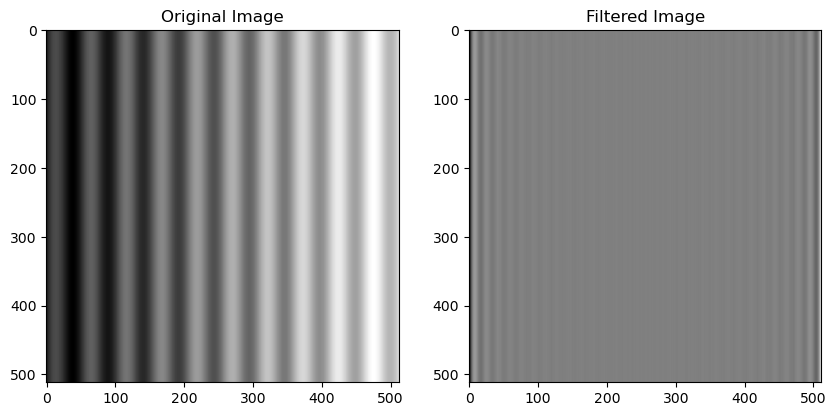

In [10]:
# image=cv2.imread("Images/noisy_image.png",0)
# imager=cv2.imread("Images/miju.jpg",0)
# imager=cv2.imread("Images/child.jpeg",0)
imager=cv2.imread("Images/noisy_image.png",0)
image = cv2.resize(imager, (512, 512), interpolation=cv2.INTER_CUBIC)

dft=np.fft.fft2(image)
dft_shift=np.fft.fftshift(dft)

rows,cols=image.shape
crow,ccol=rows//2,cols//2

notch_filter=np.ones((rows,cols),np.uint8)
notch_size=10

notch_filter[crow-30:crow+30,ccol-30:ccol+30]=0

filtered_dft=dft_shift*notch_filter

idft_shift=np.fft.ifftshift(filtered_dft)
filtered_image=np.fft.ifft2(idft_shift).real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(image, cmap='gray'), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(filtered_image, cmap='gray'), plt.title("Filtered Image")
plt.show()

Gaussian Notch Reject Filter (GNRF)

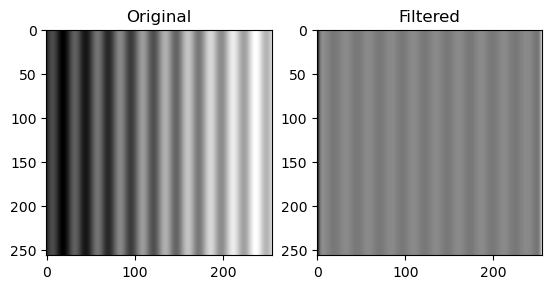

In [11]:
def gaussian_notch_reject_filter(shape, notch_centers, D0):
    rows, cols = shape
    H = np.ones((rows, cols))
    for u, v in notch_centers:
        for i in range(rows):
            for j in range(cols):
                D1 = np.sqrt((i - u)**2 + (j - v)**2)
                D2 = np.sqrt((i - (rows-u))**2 + (j - (cols-v))**2)
                H[i, j] *= (1 - np.exp(-(D1**2 + D2**2) / (2 * D0**2)))
    return H

# Example usage
image = cv2.imread("Images/noisy_image.png", 0)
dft = np.fft.fftshift(np.fft.fft2(image))

notch_centers = [(128, 128), (140, 140)]  # Example noise frequencies
D0 = 20  # Cutoff frequency

H = gaussian_notch_reject_filter(image.shape, notch_centers, D0)
filtered_dft = dft * H
filtered_image = np.fft.ifft2(np.fft.ifftshift(filtered_dft)).real

# Show result
plt.subplot(1,2,1), plt.imshow(image, cmap="gray"), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(filtered_image, cmap="gray"), plt.title("Filtered")
plt.show()


Butterworth

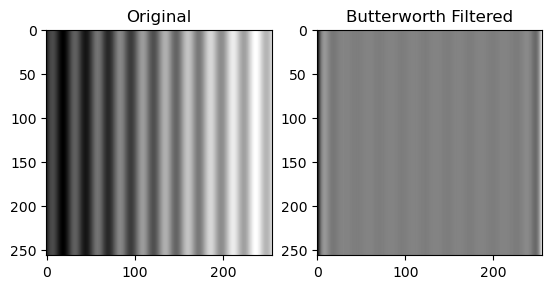

In [12]:
def butterworth_notch_reject_filter(shape, notch_centers, D0, n):
    rows, cols = shape
    H = np.ones((rows, cols))
    for u, v in notch_centers:
        for i in range(rows):
            for j in range(cols):
                D1 = np.sqrt((i - u)**2 + (j - v)**2)
                D2 = np.sqrt((i - (rows-u))**2 + (j - (cols-v))**2)
                H[i, j] *= (1 / (1 + ((D0**2 / (D1**2 + D2**2 + 1e-5))**(2*n))))
    return H

# Example usage
n = 2  # Filter order
H_butterworth = butterworth_notch_reject_filter(image.shape, notch_centers, D0, n)
filtered_dft_butter = dft * H_butterworth
filtered_image_butter = np.fft.ifft2(np.fft.ifftshift(filtered_dft_butter)).real

# Show result
plt.subplot(1,2,1), plt.imshow(image, cmap="gray"), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(filtered_image_butter, cmap="gray"), plt.title("Butterworth Filtered")
plt.show()


Inverse filtering

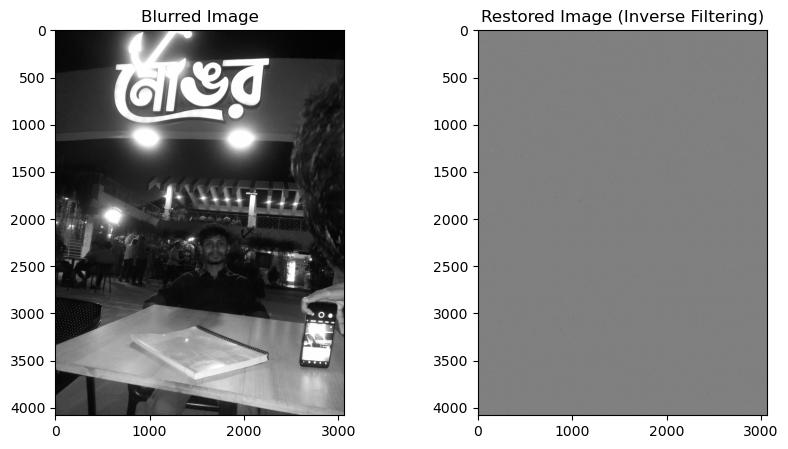

In [15]:
def inverse_filtering(blurred_img, H):
    # Convert image to frequency domain
    G = np.fft.fft2(blurred_img)
    G_shifted = np.fft.fftshift(G)

    # Apply inverse filter (avoid division by zero)
    H_safe = np.where(H == 0, 1e-5, H)  # Avoid division by zero
    F_hat = G_shifted / H_safe

    # Convert back to spatial domain
    restored_img = np.fft.ifft2(np.fft.ifftshift(F_hat)).real
    return np.clip(restored_img, 0, 255).astype(np.uint8)

# Load blurred image
blurred_img = cv2.imread("Images/miju.jpg", 0)

# Generate Gaussian blur kernel in frequency domain
rows, cols = blurred_img.shape
X, Y = np.meshgrid(np.linspace(-1, 1, cols), np.linspace(-1, 1, rows))
D = np.sqrt(X**2 + Y**2)
H = np.exp(- (D**2) / (2 * (0.1**2)))  # Gaussian blur kernel

# Apply inverse filtering
restored_image = inverse_filtering(blurred_img, H)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(blurred_img, cmap='gray'), plt.title("Blurred Image")
plt.subplot(1,2,2), plt.imshow(restored_image, cmap='gray'), plt.title("Restored Image (Inverse Filtering)")
plt.show()


In [ ]:
def wiener_filtering(blurred_img, H, K):
    # Convert image to frequency domain
    G = np.fft.fft2(blurred_img)
    G_shifted = np.fft.fftshift(G)

    # Wiener filter equation
    H_conj = np.conj(H)
    H_abs_sq = np.abs(H) ** 2
    H_safe = np.where(H_abs_sq == 0, 1e-5, H_abs_sq)  # Avoid division by zero

    # Apply Wiener filter
    F_hat = (H_conj / (H_safe + K)) * G_shifted

    # Convert back to spatial domain
    restored_img = np.fft.ifft2(np.fft.ifftshift(F_hat)).real
    return np.clip(restored_img, 0, 255).astype(np.uint8)

# Load blurred image
blurred_img = cv2.imread("blurred_image.png", 0)

# Generate Gaussian blur kernel in frequency domain
rows, cols = blurred_img.shape
X, Y = np.meshgrid(np.linspace(-1, 1, cols), np.linspace(-1, 1, rows))
D = np.sqrt(X**2 + Y**2)
H = np.exp(- (D**2) / (2 * (0.1**2)))  # Gaussian blur kernel

# Set noise-to-signal ratio (higher K means more noise assumed)
K = 0.01  

# Apply Wiener filtering
restored_image = wiener_filtering(blurred_img, H, K)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(blurred_img, cmap='gray'), plt.title("Blurred Image")
plt.subplot(1,2,2), plt.imshow(restored_image, cmap='gray'), plt.title("Restored Image (Wiener Filtering)")
plt.show()


Wiener Filtering Formula

In [ ]:
def wiener_filtering(blurred_img, H, K):
    # Convert image to frequency domain
    G = np.fft.fft2(blurred_img)
    G_shifted = np.fft.fftshift(G)

    # Wiener filter equation
    H_conj = np.conj(H)
    H_abs_sq = np.abs(H) ** 2
    H_safe = np.where(H_abs_sq == 0, 1e-5, H_abs_sq)  # Avoid division by zero

    # Apply Wiener filter
    F_hat = (H_conj / (H_safe + K)) * G_shifted

    # Convert back to spatial domain
    restored_img = np.fft.ifft2(np.fft.ifftshift(F_hat)).real
    return np.clip(restored_img, 0, 255).astype(np.uint8)

# Load blurred image
blurred_img = cv2.imread("blurred_image.png", 0)

# Generate Gaussian blur kernel in frequency domain
rows, cols = blurred_img.shape
X, Y = np.meshgrid(np.linspace(-1, 1, cols), np.linspace(-1, 1, rows))
D = np.sqrt(X**2 + Y**2)
H = np.exp(- (D**2) / (2 * (0.1**2)))  # Gaussian blur kernel

# Set noise-to-signal ratio (higher K means more noise assumed)
K = 0.01  

# Apply Wiener filtering
restored_image = wiener_filtering(blurred_img, H, K)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(blurred_img, cmap='gray'), plt.title("Blurred Image")
plt.subplot(1,2,2), plt.imshow(restored_image, cmap='gray'), plt.title("Restored Image (Wiener Filtering)")
plt.show()
